<a href="https://colab.research.google.com/github/jansoe/AICA/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
# Es lohnt sich zu überprüfen, ob man auch wirklich eine GPU bekommen hat.
print("Anzahl der zugewiesenen GPUs:", len(tf.config.list_physical_devices('GPU')))

Anzahl der zugewiesenen GPUs: 1


# Autoencoder

Der [Autoencoder](https://de.wikipedia.org/wiki/Autoencoder) besteht aus zwei Teilen: einem *Encoder* und einem *Decoder*. Der Encoder bekommt als Input ein Bild und generiert als Output einen *Code* oder *Embedding* der eine kompakte Repräsentation wichtiger Merkmale des Inputs darstellt. Dieses *Embedding* wird dann dem *Decoder* als Input übergeben. Die Aufgabe des Decoders besteht darin, aus dem Code wieder das ursprüngliche Inputbild möglichst gut zu rekonstruieren. 

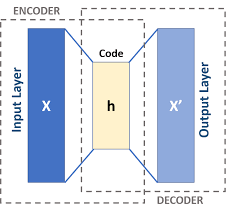
(Quelle:https://upload.wikimedia.org/wikipedia/commons/3/37/Autoencoder_schema.png)


Der ursprüngliche Zweck eines Autoencoders ist die Kompression mithilfe einer geeigneten Kodierung. Dieser Code (also die kompakte Repräsentation des Inputs) hat zumeist eine deutlich niedrigere Dimensionalität als das Inputbild. Schafft man es, das Bild aus dem Code zu rekonstruieren, hat man also die im Bild enthaltene relevante Information in einem kompakteren Format gespeichert. Da die Suche nach einer möglichst guten Kodierung dank maschinellen Lernens automatisch passiert, wurde das ganze Autoencoder getauft.

Trainiert werden Autoencoder so, dass man für Input und gewünschte Ausgabe jeweils dasselbe Bild präsentiert. Wird der Autoencoder auf einer großen Anzahl von Bildern trainiert, lernt er die in den Bildern enhaltene Struktur und deren Statistik. 

Wie Ihnen vielleicht schon aufgefallen ist, haben wir es hier mit einem Beispiel von *self-supervised learning* zu tun. Es werden also nicht, wie beim Training von Klassifikationsnetzwerken, annotierte Daten benötigt sondern einfach nur die Bilder, die gleichzeitig Input und gewünschte Ausgabe (Teacher-Signal) sind.

Neben der Komprimierung ergibt sich aus der Art wie Autoencoder trainiert werden auch die Möglichkeit, den Decoder getrennt zu verwenden. Ebenso wie der Encoder muss der Decoder die inhärente Struktur der Daten lernen, um die Bilder möglichst gut rekonstruieren zu können. Wir können den Decoder also dazu benutzen, neue Bilder zu generieren. 

Im Folgenden nehmen wir uns wieder den guten alten MNIST-Datensatz vor, um die Funktionsweise des Autoencoders kennenzulernen.

### Laden des MNIST-Datensatzes

Viele der folgenden Schritte kennen Sie bereits. Wir importieren einige Bibliotheken und laden mit Hilfe von `Keras` den MNIST-Datensatz herunter.

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from IPython import display

In [ ]:
# Herunterladen des Datensatzes
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images.shape

11501568/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [ ]:
# Hinzufügen einer weiteren Dimension damit der Tensor alle erforderlichen Dimensionen für
# Bilddaten in Keras hat (sample, width, height, channel)
train_images = train_images[:,:,:,np.newaxis].astype('float32')
# Und Skalierung auf den Bereich [0,1]
train_images_01 = train_images / 255.

test_images = test_images[:,:,:,np.newaxis]
test_images_01 = test_images / 255.

train_images_01.shape

(60000, 28, 28, 1)

### Encoder und Decoder

Wie bereits erwähnt, besteht der Autoencoder aus einem *Encoder* und einem *Decoder*, die wir hier als getrennte Netzwerkteile implementieren. Das *Embedding*, also die Schicht, die die Ausgabe der Encoders und die Eingabe des Decoders darstellt, wird im Fachjargon oft *latente Variable* genannt, da sie *unter der Oberfläche* liegt und nicht direkt einsehbar ist. 

Wir müssen für unsere *latente Variable* eine Dimensionalität festlegen, also die Anzahl der Elemente/units, aus der das Embedding bestehen soll. Die MNIST-Ziffern haben eine Auflösung von 28x28 Pixel. Die in den Bildern enthaltene Information beschränkt sich aber auf eine von zehn Ziffern. Es ist also davon auszugehen, dass die Information sehr stark komprimiert werden kann. Wir wählen entsprechend ein Embedding mit acht Kanälen.

In [ ]:
latent_dim = 8

encoder = tf.keras.Sequential(
    name='encoder',
    layers = [
        layers.InputLayer(input_shape=(28, 28, 1)),
        layers.Conv2D(filters=32, kernel_size=3, strides=2, activation='relu'),
        layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu'),
        layers.Flatten(),
        layers.Dense(latent_dim),
        ]
    )

Der Decoder soll nun die acht Kanäle der Ausgabeschicht des Encoders wieder in ein 28x28-Pixelbild umwandeln. Wir können uns den Decoder also als eine Art *umgedrehten* Encoder vorstellen. Hierfür bietet sich die in `Keras` implementierte Klasse `Conv2DTranspose` an, die die entsprechende Umkehroperation einer `Conv2D`-Schicht umsetzt.

In [ ]:
decoder = tf.keras.Sequential(
    name = 'decoder', 
    layers = [
        layers.InputLayer(input_shape=(latent_dim,)),
        layers.Dense(units=7*7*32, activation=tf.nn.relu),
        layers.Reshape(target_shape=(7, 7, 32)),
        layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same", activation='relu'),
        layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation='relu'),
        layers.Conv2DTranspose(filters=1,  kernel_size=3, strides=1, padding="same", activation='sigmoid'),
        ]
    )

Wir können die beiden Netzwerke jetzt verbinden, indem wir ein Modell generieren, dessen *Input* der input des *Encoders* ist, während der *Output* der Output des *Decoders* ist,  dem zuvor der *Output* des Encoders (also das *Embedding*) als *Input* gegeben wurde. 

In [ ]:
# autoencoder = tf.keras.Sequential([encoder, decoder])
# autoencoder = tf.keras.Model(inputs=encoder.input, outputs=decoder(encoder.output))
encoder_model = encoder(encoder.input)  # kleiner Hack, um einen besseren Graphen zu bekommen
autoencoder = tf.keras.Model(inputs=encoder.input, outputs=decoder(encoder_model))
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

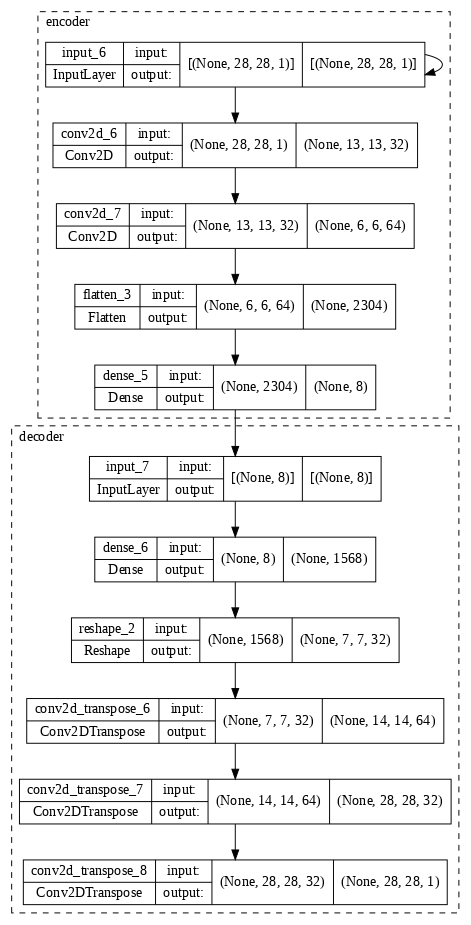

In [ ]:
tf.keras.utils.plot_model(autoencoder, show_shapes=True, dpi=70, expand_nested=True)

Unser untrainiertes Modell ist bislang lediglich mit Zufallszahlen gefüllt und generiert daher aus den Inputbildern einen Ameisenkrieg der Größe 28x28.

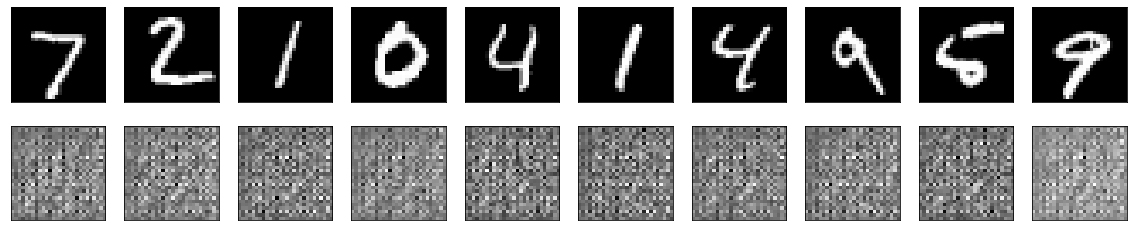

In [ ]:
decoded_imgs = autoencoder.predict(test_images_01)

n_plot = 10
plt.figure(figsize=(20, 4))
for i in range(n_plot):
    # display original
    ax = plt.subplot(2, n_plot, i+1)
    plt.imshow(test_images_01[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n_plot, i+n_plot+1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Trainieren des Modells

Wir trainieren jetzt den Autoencoder anhand der Ziffernbilder. Beachten Sie, dass `x` und `y` in der `fit`-Funktion als Trainingsdaten *und* gewünschte Ausgabe *dieselbe* Variable sind, da der Autoencoder diese rekonstrukieren soll.

In [ ]:
autoencoder.fit(
    x = train_images_01, 
    y = train_images_01,
    epochs=40,
    batch_size=256,
    shuffle=True,
    validation_data=(test_images_01, test_images_01)
)

Epoch 1/40
235/235 [==============================] - 5s 15ms/step - loss: 0.2759 - val_loss: 0.1624
Epoch 2/40
235/235 [==============================] - 3s 13ms/step - loss: 0.1454 - val_loss: 0.1349
Epoch 3/40
235/235 [==============================] - 3s 13ms/step - loss: 0.1324 - val_loss: 0.1281
Epoch 4/40
235/235 [==============================] - 3s 13ms/step - loss: 0.1272 - val_loss: 0.1245
Epoch 5/40
235/235 [==============================] - 3s 13ms/step - loss: 0.1240 - val_loss: 0.1218
Epoch 6/40
235/235 [==============================] - 3s 14ms/step - loss: 0.1219 - val_loss: 0.1200
Epoch 7/40
235/235 [==============================] - 3s 13ms/step - loss: 0.1203 - val_loss: 0.1192
Epoch 8/40
235/235 [==============================] - 3s 13ms/step - loss: 0.1191 - val_loss: 0.1180
Epoch 9/40
235/235 [==============================] - 3s 13ms/step - loss: 0.1182 - val_loss: 0.1169
Epoch 10/40
235/235 [==============================] - 3s 14ms/step - loss: 0.1172 - val_lo

Jetzt können wir das Netzwerk erneut Output zu den Testdaten erzeugen lassen.

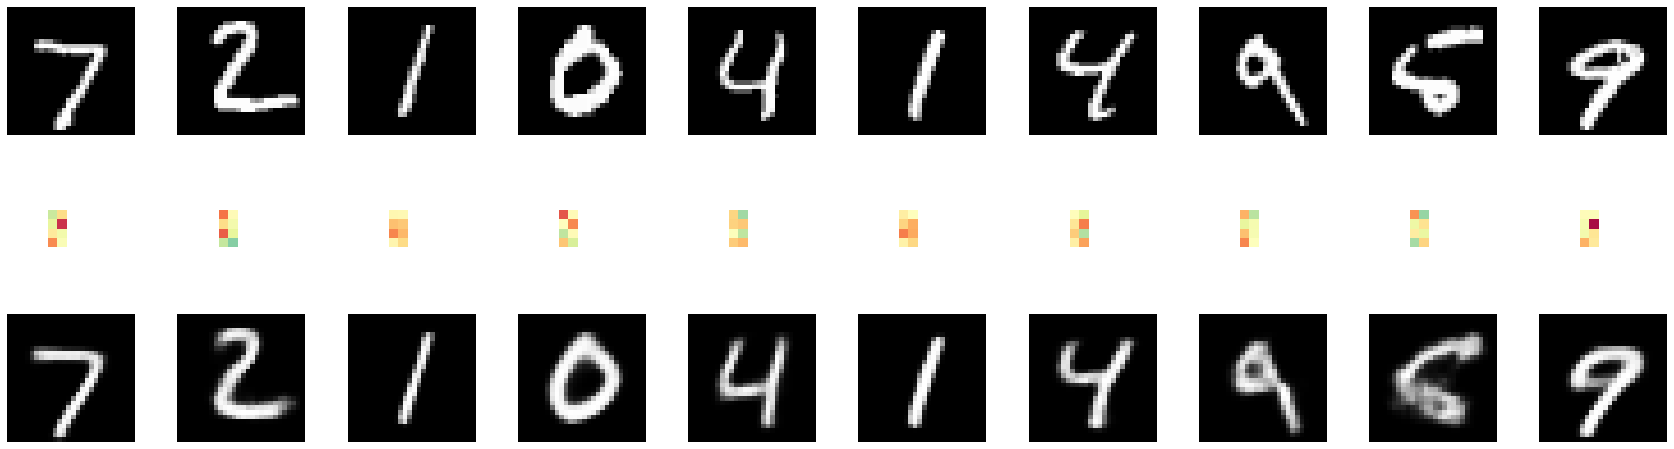

In [ ]:
encoded_imgs = encoder.predict(test_images_01)
de_encoded_imgs = decoder.predict(encoded_imgs)

n = 10
plt.figure(figsize=(30, 8))
for i in range(n):

    # display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(test_images_01[i].reshape(28, 28))
    plt.axis('off')

    # encodint original
    ax = plt.subplot(3, n, n+i+1)
    plt.imshow(encoded_imgs[i].reshape(-1, 2), cmap=plt.cm.Spectral, vmin=-10, vmax=10)
    plt.xlim((-5, 9))
    plt.ylim((-5, 9))
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(3, n, 2*n+i+1)
    plt.imshow(de_encoded_imgs[i].reshape(28, 28))
    plt.axis('off')

Wie wir sehen, erzeugt das Modell Ziffern, die dem Input sehr ähnlich sind. In der Mitte der Darstellung sehen sie den jeweils zugehörigen *Code*. Es ist wichtig sich vor Augen zu führen, dass sämtliche Information im Autoencoder durch diesen *Flaschenhals* fließen muss. Das heisst, die Outputbilder werden aus dem achtstelligen Code generiert und nicht aus dem Inputbild.

### **Aufgabe**: Embedding Größe
Experimentieren Sie mit der Größe des Embedding. Was beobachten Sie, wenn z.B. es nur 2-dimensional ist?

### Der Decoder als generatives Modell

Da der Decoder nur auf Basis der *latent variable* arbeitet, können wir ihn auch isoliert benutzen. Wir können auf Basis von *Embeddings* mit beliebigen Werten zugehörige Bilder generieren lassen. 

Versuchen wir zunächst einen zufälligen Embedding:

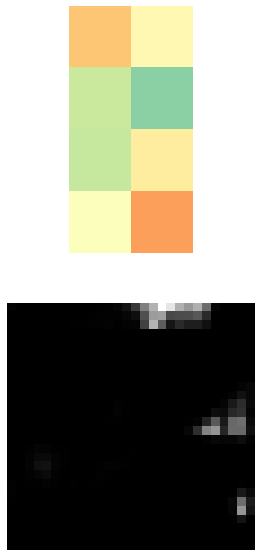

In [ ]:
#np.random.seed(44)
random_encoding = (np.random.rand(latent_dim)-0.5)*10
random_img = decoder.predict(random_encoding[np.newaxis]).reshape((28,28))

plt.figure(figsize=(5,10))
plt.subplot(2,1,1)
plt.imshow(random_encoding.reshape((4,2)),  cmap=plt.cm.Spectral, vmin=-10, vmax=10)
plt.axis('off')
plt.subplot(2,1,2)
plt.imshow(random_img)
_ = plt.axis('off')

Der *latente Raum*, also alle möglichen Kombinationen von Zahlen, die das Embedding abdecken kann, ist riesig, und nur in bestimmten Bereichen haben sich durch das Training *Cluster* gebildet, in denen die einzelnen Ziffern abgebildet sind. Wir sehen aber, dass auch ein zufällig gewählter Code ein Gebilde hervorbringt, dass die gundlegende Struktur einer handgeschriebenen Ziffer besitzt. 

Wir können auch gezielt einen Punkt im Embedding-Raum aussuchen, indem wir bei dem Embedding einer echten Zahl starten. Wählen wir anschließend eine zufällige Veränderungsrichtung, und addieren diese mit immer größer werdenden Gewichtungen auf den Code, so sieht das dekodierte Bild zunächst noch aus wie die ursprüngliche Zahl. Doch je mehr wir uns vom ursprünglichen Code entfernen, desto mehr verschwindet unsere Zahl.

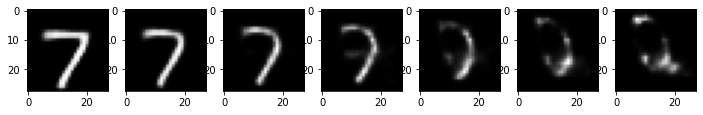

In [ ]:
code = encoder.predict(test_images_01[0][None,:,:,:])
direction = np.random.randn(*code.shape)
displacements = [0,.5,1,1.5,2, 2.5, 3]
plt.figure(figsize=(12,10))
for i,d in enumerate(displacements):
    plt.subplot(1,len(displacements),i+1)
    img = decoder.predict(code+direction*d)
    _ = plt.imshow(img.squeeze())

Wir haben es bei unserem Code also mit einem *kontinuierlichen* Raum zu tun, in dem jeder Punkt uns ein Ergebnis gibt und nahe beieinanderliegende Punkte ähnliche Bilder hervorbringen. 

Wir können zum Beispiel auch ein *Morphing* zwischen zwei Zahlen generieren, in dem wir uns im Code-Raum von einer Zahl zur nächsten bewegen und unterwegs einige Bilder generieren:

### **Aufgabe**: Morphen von Codes
- Starten sie mit 2 unterschiedlichen Bildern und bilden Sie die Embeddings
- bilden Sie jeweils das gewichtete Mittel dieser Embeddings `morphed = (1-alpha) * encoded_imgs[start_img_number] + alpha * encoded_imgs[end_img_number]` für verschiedene Werte von `alpha = 0 bis 1`
- visualiseren sie das Ergebniss wenn Sie diese "neuen" Embeddings dekodieren 